## STO-3G Benchmarking

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import glob
import torch
import time
from cace.tasks import LightningTrainingTask
from deeporb.data import OrbDataset, OrbData
from deeporb.ceonet import CEONet
from cace.models import NeuralNetworkPotential
from deeporb.atomwise import AttentionAtomwise
from cace.tasks import GetLoss
from deeporb.metrics import Metrics
import numpy as np
import matplotlib.pyplot as plt
import hashlib
from pathlib import Path
import h5py

/home/king1305/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/king1305/.local/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
#Write here
DATA_NAME = "sto3g_occ"
SUBSET_SIZE = "10000"

#Model params
CUTOFF = 7.6
LINMAX = 1
LOMAX = 2
NC = 16
LAYERS = 2
N_RBF = 16
N_RSAMPLES = 16
STACKING = True
IRREP_MIXING = False
CHARGE_EMBEDDING = False

#Data params
BATCH_SIZE = 128
IN_MEMORY = True
AVGE0 = -0.6605
SIGMA = 0.2801

DEV_RUN = False
LR = 0.001
MAX_STEPS = 600000

root = f"data/{DATA_NAME.split('.')[0]}_{SUBSET_SIZE}.h5"
torch.multiprocessing.set_sharing_strategy('file_system')
in_memory = True

print("Making dataset...")
data = OrbData(data_path=root,batch_size=BATCH_SIZE,cutoff=CUTOFF,avge0=AVGE0,sigma=SIGMA)
data.setup() #Suuuuuper slow

Making dataset...
calling prepare data
reading h5 file
calling setup
10000
8000


In [4]:
#Make model & load ckpt
representation = CEONet(NC,cutoff=CUTOFF,n_rbf=N_RBF,n_rsamples=N_RSAMPLES,stacking=STACKING,irrep_mixing=IRREP_MIXING,
                        linmax=LINMAX,lomax=LOMAX,layers=LAYERS,charge_embedding=CHARGE_EMBEDDING)

atomwise = AttentionAtomwise(
                    output_key='pred_energy',
                    n_hidden=[32,16],
                    attention_hidden_nc=128,
                    avge0=AVGE0,sigma=SIGMA,
                    bias=True
                   )

model = NeuralNetworkPotential(
    input_modules=None,
    representation=representation,
    output_modules=[atomwise]
)

e_loss = GetLoss(
            target_name="energy_ssh",
            predict_name='pred_energy',
            loss_fn=torch.nn.MSELoss(),
            loss_weight=1,
            )
losses = [e_loss]

e_metric = Metrics(
            target_name="energy",
            predict_name='pred_energy',
            name='e',
            metric_keys=["mae"],
            avge0=AVGE0,sigma=SIGMA,
            per_atom=False,
        )
metrics = [e_metric]

task = LightningTrainingTask(model,losses=losses,metrics=metrics,
                             logs_directory="lightning_logs",name="test_ex",
                             scheduler_args={'mode': 'min', 'factor': 0.8, 'patience': 10},
                             optimizer_args={'lr': LR},
                            )

#You need to load the best_model_state.pth here:
pth = f"model_eval/best_models_polaris/{DATA_NAME}_1000000/best_model_state.pth"
state_dict = torch.load(pth,map_location='cpu',weights_only=True)
task.model.model.load_state_dict(state_dict)

<All keys matched successfully>

In [5]:
import scipy
import matplotlib.pyplot as plt
import torch
import numpy as np

class Benchmark:
    def __init__(self,data,task):
        self.model = task.model.model
        self.data = data
        self.avge0 = task.model.model.output_modules[0].avge0
        self.sigma = task.model.model.output_modules[0].sigma

    def predict(self):
        pred_energies = []
        true_energies = []
        self.model.cuda()
        self.model.eval()
        with torch.no_grad():
            for batch in self.data.test_dataloader():
                batch.cuda()
                out = self.model(batch)
                pred_energy = out["pred_energy"] * self.sigma + self.avge0
                pred_energy = pred_energy.cpu().detach().numpy()
                pred_energies.append(pred_energy)
                true_energy = batch["energy"].cpu().detach().numpy()
                true_energies.append(true_energy)
                torch.cuda.empty_cache()
        pred_energies = np.hstack(pred_energies)
        true_energies = np.hstack(true_energies)
        self.pred = pred_energies
        self.true = true_energies
        hartree_to_ev = 27.2114
        mae = np.abs(self.pred - self.true).mean()
        mae = np.round(mae*hartree_to_ev,4)
        r2 = np.round(scipy.stats.pearsonr(self.true,self.pred)[0]**2,3)
        self.mae = mae
        self.r2 = r2
        print("MAE:",mae)
        print("R2:",r2)
        return self.true, self.pred
        
obj = Benchmark(data,task)
true_energies, pred_energies = obj.predict()

MAE: 0.0077
R2: 1.0


MAE: 0.0077
R2: 1.0


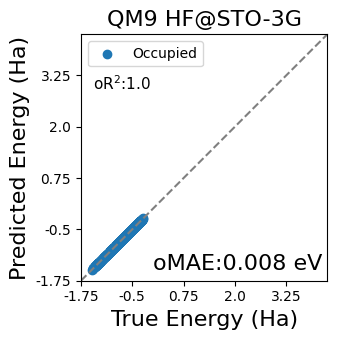

In [6]:
obj_occ = Benchmark(data,task)
occ_true,occ_pred = obj_occ.predict()

# obj_virt = Benchmark("sto3g_virt")
# virt_true,virt_pred = obj_virt.predict()

import scipy
import matplotlib.pyplot as plt
plt.figure(figsize=(3.5,3.5))
plt.scatter(occ_true,occ_pred,label="Occupied")
# plt.scatter(virt_true,virt_true,label="Virtual")
hartree_to_ev = 27.2114
occ_mae = np.round(np.abs(occ_pred - occ_true).mean()*hartree_to_ev,3)
occ_r2 = np.round(scipy.stats.pearsonr(occ_true,occ_pred)[0]**2,2)
# virt_mae = np.round(np.abs(virt_pred - virt_true).mean()*hartree_to_ev,2)
# virt_r2 = np.round(scipy.stats.pearsonr(virt_true,virt_pred)[0]**2,2)
xmin, xmax = -1.75, 4.25
x = y = np.arange(xmin,xmax+1)
plt.plot(x,y,linestyle="--",color="grey")
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)
tcks = np.round(np.arange(xmin,xmax,1.25),2)
plt.xticks(tcks,tcks)
plt.yticks(tcks,tcks)
plt.gca().set_aspect('equal')
plt.legend()
djvfont = {'fontname':'DejaVu Sans'}
fs=16
plt.ylabel("Predicted Energy (Ha)",fontsize=fs,**djvfont)
plt.xlabel("True Energy (Ha)",fontsize=fs,**djvfont)
plt.title("QM9 HF@STO-3G",fontsize=fs,**djvfont)
plt.text(-1.45,2.9,f"oR$^2$:{occ_r2}",fontsize=11,**djvfont)
# plt.text(-1.8,2.4,f"vR$^2$:{virt_r2}",fontsize=11,**djvfont)
plt.text(0,-1.5,f"oMAE:{occ_mae} eV",fontsize=fs,**djvfont)
# plt.text(0.3,-0.75,f"vMAE:{virt_mae} eV",fontsize=fs,**djvfont)
plt.tight_layout()
# plt.savefig("figures/sto3g_parity.png",dpi=500)